Finding Critical Points using RNNs

 - [Data Prep notebook](https://www.kaggle.com/code/werus23/sleep-critical-point-prepare-data)
 - Training notebook - this
 - [Inference Notebook](https://www.kaggle.com/code/werus23/child-sleep-critical-point-regression)

Credits:

 - idea: https://www.kaggle.com/competitions/child-mind-institute-detect-sleep-states/discussion/441470
 - dataloader: https://www.kaggle.com/code/henriupton/efficient-loading-memory-usage-visualizations-cmi
 - arch: https://www.kaggle.com/competitions/tlvmc-parkinsons-freezing-gait-prediction/discussion/416410

# 1. Configuration

In [1]:
import pandas as pd
import numpy as np
import gc
import time
import json
from datetime import datetime
import matplotlib.pyplot as plt
import os
import joblib
import random
import math
from tqdm.auto import tqdm 

from scipy.interpolate import interp1d

from math import pi, sqrt, exp
import sklearn,sklearn.model_selection
import torch
from torch import nn,Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from sklearn.metrics import average_precision_score
from timm.scheduler import CosineLRScheduler
plt.style.use("ggplot")

from pyarrow.parquet import ParquetFile
import pyarrow as pa 
import ctypes

def normalize(y):
    mean = y[:,0].mean().item()
    std = y[:,0].std().item()
    y[:,0] = (y[:,0]-mean)/(std+1e-16)
    mean = y[:,1].mean().item()
    std = y[:,1].std().item()
    y[:,1] = (y[:,1]-mean)/(std+1e-16)
    return y

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
EPOCHS = 5
WARMUP_PROP = 0.2
BS = 1
WORKERS = 4
TRAIN_PROP = 0.9
max_chunk_size = 150000
if device=='cpu':
    torch.set_num_interop_threads(WORKERS)
    torch.set_num_threads(WORKERS)

In [3]:
def plot_history(history, model_path=".", show=True):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure()
    plt.plot(epochs, history["train_loss"], label="Training Loss")
    plt.plot(epochs, history["valid_loss"], label="Validation Loss")
    plt.title("Loss evolution")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(model_path, "loss_evo.png"))
    if show:
        plt.show()
    plt.close()

#     plt.figure()
#     plt.plot(epochs, history["valid_mAP"])
#     plt.title("Validation mAP evolution")
#     plt.xlabel("Epochs")
#     plt.ylabel("mAP")
#     plt.savefig(os.path.join(model_path, "mAP_evo.png"))
#     if show:
#         plt.show()
#     plt.close()

    plt.figure()
    plt.plot(epochs, history["lr"])
    plt.title("Learning Rate evolution")
    plt.xlabel("Epochs")
    plt.ylabel("LR")
    plt.savefig(os.path.join(model_path, "lr_evo.png"))
    if show:
        plt.show()
    plt.close()

In [4]:
class ResidualBiGRU(nn.Module):
    def __init__(self, hidden_size, n_layers=1, bidir=True):
        super(ResidualBiGRU, self).__init__()

        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.gru = nn.GRU(
            hidden_size,
            hidden_size,
            n_layers,
            batch_first=True,
            bidirectional=bidir,
        )
        dir_factor = 2 if bidir else 1
        self.fc1 = nn.Linear(
            hidden_size * dir_factor, hidden_size * dir_factor * 2
        )
        self.ln1 = nn.LayerNorm(hidden_size * dir_factor * 2)
        self.fc2 = nn.Linear(hidden_size * dir_factor * 2, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)

    def forward(self, x, h=None):
        res, new_h = self.gru(x, h)
        # res.shape = (batch_size, sequence_size, 2*hidden_size)

        res = self.fc1(res)
        res = self.ln1(res)
        res = nn.functional.relu(res)

        res = self.fc2(res)
        res = self.ln2(res)
        res = nn.functional.relu(res)

        # skip connection
        res = res + x

        return res, new_h

class MultiResidualBiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, out_size, n_layers, bidir=True):
        super(MultiResidualBiGRU, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.n_layers = n_layers

        self.fc_in = nn.Linear(input_size, hidden_size)
        self.ln = nn.LayerNorm(hidden_size)
        self.res_bigrus = nn.ModuleList(
            [
                ResidualBiGRU(hidden_size, n_layers=1, bidir=bidir)
                for _ in range(n_layers)
            ]
        )
        self.fc_out = nn.Linear(hidden_size, out_size)

    def forward(self, x, h=None):
#         print("forward_size", x.shape)
        # if we are at the beginning of a sequence (no hidden state)
        if h is None:
            # (re)initialize the hidden state
            h = [None for _ in range(self.n_layers)]

        x = self.fc_in(x)
        x = self.ln(x)
        x = nn.functional.relu(x)

        new_h = []
        for i, res_bigru in enumerate(self.res_bigrus):
            x, new_hi = res_bigru(x, h[i])
            new_h.append(new_hi)

        x = self.fc_out(x)
#         x = F.normalize(x,dim=0)
        return x, new_h  # log probabilities + hidden states

# Define Dataset

In [5]:
def reduce_mem_usage(df): #데이터 프레임을 받아 가장 작은 자료형으로 표현함으로서 메모리 최적화
    
    """ 
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.        
    """
    
    for col in df.columns: #모든 열에 대해 타입을 받아, 특정 타입시 메모리 최적화 처 
        col_type = df[col].dtype

        if col_type != object and not is_datetime64_ns_dtype(df[col]) and not 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int32)  
            else:

                df[col] = df[col].astype(np.float16)
        
    return df

In [6]:
night_mean_anglez = {'038441c925bb': 1.1187915, '03d92c9f6f8a': 0.613011, '0402a003dae9': 1.0225449, '04f547b8017d': 1.0432671, '05e1944c3818': 0.94554585, '062cae666e2a': 0.8978027, '062dbd4c95e6': 1.1887305, '08db4255286f': 0.733972, '0a96f4993bd7': 0.77553415, '0cd1e3d0ed95': 0.6662205, '0ce74d6d2106': 0.857557, '0cfc06c129cc': 0.6661924, '0d0ad1e77851': 0.58548117, '0dee4fda51c3': 0.5768956, '0ec9fc461819': 0.7549095, '0ef7d94fde99': 1.1257325, '0f572d690310': 0.754275, '0f9e60a8e56d': 0, '10469f6765bf': 0.9047967, '1087d7b0ff2e': 1.0007815, '10f8bc1f7b07': 0.7370249, '12d01911d509': 0.7249254, '1319a1935f48': 0.6683257, '137771d19ca2': 0.96921015, '137b99e936ab': 0.72838277, '13b4d6a01d27': 0.34867227, '148471991ffb': 0.78237635, '154fe824ed87': 0.76157564, '16fe2798ed0f': 0.8177971, '1716cd4163b2': 0.72856826, '1762ab70ec76': 0.7582628, '188d4b7cd28b': 0.5880476, '18a0ca03431d': 0.6891888, '18b61dd5aae8': 0.94065607, '1955d568d987': 0.6801891, '1b92be89db4c': 0.71106493, '1c7c0bad1263': 0.6294838, '1d4569cbac0f': 0.7370919, '1e6717d93c1d': 0.4621887, '1f96b9668bdf': 0.99449664, '207eded97727': 0.7236806, '25e2b3dd9c3b': 0.6876429, '2654a87be968': 0.879418, '27f09a6a858f': 0.94829386, '280e08693c6d': 0.8386909, '292a75c0b94e': 0.96594083, '29c75c018220': 0.6078258, '29d3469bd15d': 0.8132134, '2b0a1fa8eba8': 1.040273, '2b8d87addea9': 1.1364268, '2cd2340ca14d': 0.94766027, '2e9ced2c7976': 0.4151749, '2f7504d0f426': 0.7813868, '2fbbee1a38e3': 0.89707476, '2fc653ca75c7': 0, '31011ade7c0a': 1.1654006, '3318a0e3ed6f': 0.9452682, '33ceeba8918a': 0.72270656, '3452b878e596': 0.88471925, '349c5562ee2c': 0.89899206, '35826366dfc7': 0.56988615, '361366da569e': 0.8691948, '3664fe9233f9': 0.6871904, '3665c86afaf5': 0.8818509, '390b487231ce': 0, '3a9a9dc2cbd9': 0.6528986, '3aceb17ef7bd': 0.66215515, '3be1545083b7': 0.7154904, '3be2f86c3e45': 0.84141326, '3c336d6ba566': 0.64449054, '3d53bfea61d6': 0.82451224, '3df0da2e5966': 0.66478217, '405df1b41f9f': 0.71608835, '40dce6018935': 0.9324282, '416354edd92a': 0.6398183, '449766346eb1': 0.91892344, '44a41bba1ee7': 1.3692813, '44d8c02b369e': 0.6403559, '4743bdde25df': 0.6645648, '483d6545417f': 0.8158137, '4a31811f3558': 0.7635562, '4ab54be1a403': 0.8493288, '4ac356361be9': 0.96947926, '4b45c36f8f5a': 0.8736195, '4feda0596965': 1.2144126, '519ae2d858b0': 0.8158304, '51b23d177971': 0.82735497, '51c49c540b4e': 0.85595506, '51fdcc8d9fe7': 0.6393968, '559ffb7c166a': 0.7018147, '55a47ff9dc8a': 0.85984236, '55b7f5c99930': 0.7848327, '599ca4ed791b': 0.7708978, '5aad18e7ce64': 0.79591954, '5acc9d63b5fd': 0.6067399, '5c088d7e916c': 0.7447541, '5c55a5e717d6': 0.5604853, '5e816f11f5c3': 0.44547185, '5f40907ec171': 0.5886716, '5f76965e10cf': 0.81249326, '5f94bb3e1bed': 0.67149985, '5ffd5e1e81ac': 0.71617794, '601559e1777d': 0.70525765, '60d31b0bec3b': 1.6656262, '60e51cad2ffb': 0.89404136, '612aa8ba44e2': 0.8546206, '653622ac8363': 0.5279275, '655f19eabf1e': 0.7035092, '67f5fc60e494': 1.058045, '694faf956ebf': 0.67991275, '6a4cd123bd69': 0.6622976, '6bf95a3cf91c': 1.4158154, '6ca4f4fca6a2': 0.52182674, '6d6b9d22d48a': 0.47799122, '6ee4ade1f2bd': 1.3426831, '702bb5387b1e': 0.83413893, '703b5efa9bc1': 0.6582397, '72ba4a8afff4': 0.5987733, '72bbd1ac3edf': 0.82283974, '72d2234e84e4': 0.7152389, '73fb772e50fb': 1.265562, '7476c0bd18d2': 0.98161113, '7504165f497d': 0.9229092, '752900afe3a6': 1.0226392, '76237b9406d5': 0.34080267, '77ca4db83644': 0.6672394, '7822ee8fe3ec': 0.75470126, '78569a801a38': 0.87128234, '785c9ca4eff7': 1.0489602, '7df249527c63': 0.5417263, '7fd4284b7ee8': 0.5168737, '804594bb1f06': 0.525503, '808652a666c6': 0.8039425, '83fa182bec3a': 0.7286339, '844f54dcab89': 0.7550733, '854206f602d0': 1.0585198, '87a6cbb7c4ed': 0.90955675, '8877a6586606': 0.8210334, '8898e6db816d': 1.0428969, '89bd631d1769': 0.52748746, '89c7daa72eee': 0, '8a22387617c3': 0.7340646, '8a306e0890c0': 0.6020899, '8b159a98f485': 0.62652487, '8b8b9e29171c': 1.0271848, '8becc76ea607': 0.74244756, '8e32047cbc1f': 0.59724116, '8f6f15b9f598': 0.6678175, '8fb18e36697d': 0.80191606, '90eac42a9ec9': 0.8072855, '91127c2b0e60': 0.6460039, '91cb6c98201f': 1.1380643, '9277be28a1cf': 0.71311873, '927dd0c35dfd': 0.835387, '939932f1822d': 0.6370133, '971207c6a525': 1.009409, '99237ce045e4': 0.39970273, '99b829cbad2d': 1.0138501, '9a340507e36a': 0.8748371, '9aed9ee12ae2': 0.48693106, '9b9cd7b7af8c': 0.7182811, '9c91c546e095': 0.768824, '9ddd40f2cb36': 0.811701, '9ee455e4770d': 0.7049765, '9fbdeffbe2ba': 0.90621376, 'a167532acca2': 0.4070892, 'a261bc4b7470': 0.60360664, 'a2b0a64ec9cf': 0.42732295, 'a3e59c2ce3f6': 0, 'a4e48102f402': 0.7087993, 'a596ad0b82aa': 0.589911, 'a681f9b04b21': 0.6410305, 'a81f4472c637': 1.1931177, 'a88088855de5': 0.4837347, 'a9a2f7fac455': 1.0270988, 'a9e5f5314bcb': 0.9937024, 'aa81faa78747': 1.0047008, 'ad425f3ee76d': 0.8511393, 'aed3850f65f0': 0.69533014, 'af91d9a50547': 0.72341186, 'b1831c4979da': 0.961568, 'b364205aba43': 0.5893992, 'b4b75225b224': 0.99450153, 'b7188813d58a': 0.46647733, 'b737f8c78ec5': 0.57610834, 'b750c8c1556c': 0.6125828, 'b7fc34995d0f': 0.91354984, 'b84960841a75': 0.67605126, 'ba8083a2c3b8': 0.6808961, 'bb5612895813': 0.7976387, 'bccf2f2819f8': 0.74364156, 'bdfce9ce62b9': 0.55284566, 'bf00506437aa': 0.70097876, 'bfa54bd26187': 0.889849, 'bfe41e96d12f': 0.8599972, 'c107b5789660': 0.82506084, 'c289c8a823e0': 0.7060939, 'c3072a759efb': 0.79492134, 'c38707ef76df': 0.8017649, 'c535634d7dcd': 0.9595965, 'c5365a55ebb7': 1.264032, 'c5d08fc3e040': 0, 'c6788e579967': 0.83217245, 'c68260cc9e8f': 0.56520665, 'c75b4b207bea': 0.7794059, 'c7b1283bb7eb': 0, 'c7b2155a4a47': 0.7562836, 'c7d693f24684': 0.8414989, 'c8053490cec2': 0.8136679, 'c908a0ad3e31': 0.75975287, 'ca730dbf521d': 1.3261105, 'ca732a3c37f7': 0.8278651, 'cca14d1966c1': 0.89451534, 'ccdee561ee5d': 0.5551922, 'ce85771a714c': 0.5758381, 'ce9164297046': 0.51860523, 'cf13ed7e457a': 0.63582224, 'cfeb11428dd7': 0.74099404, 'd043c0ca71cd': 0.49626586, 'd0f613c700f7': 0.6813181, 'd150801f3145': 0.8332346, 'd25e479ecbb7': 0.6260571, 'd2d6b9af0553': 0.65857244, 'd2fef7e4defd': 1.1069254, 'd3dddd3c0e00': 0.74813586, 'd515236bdeec': 0.66291326, 'd5be621fd9aa': 1.1641693, 'd5e47b94477e': 0.8784612, 'd8de352c2657': 0.7904967, 'd93b0c7de16b': 0.442435, 'd9e887091a5c': 1.0393461, 'dacc6d652e35': 0.64348793, 'db5e0ee1c0ab': 1.1122915, 'db75092f0530': 0.9672895, 'dc80ca623d71': 0.8711435, 'de6fedfb6139': 1.0050128, 'def21f50dd3c': 0.5922235, 'df33ae359fb5': 0.87062865, 'dfc3ccebfdc9': 0.76253253, 'dff367373725': 0.87213284, 'e0686434d029': 0.9617233, 'e0d7b0dcf9f3': 0.49543485, 'e11b9d69f856': 0, 'e1f2a4f991cb': 0.9603755, 'e1f5abb82285': 1.1898476, 'e2a849d283c0': 0.9168077, 'e2b60820c325': 0.96084344, 'e30cb792a2bc': 0.6416447, 'e34b496b84ce': 0.7541476, 'e4500e7e19e1': 0.84830004, 'e586cbfa7762': 0.55293155, 'e69aff66e0cb': 0.9869858, 'e6ddbaaf0639': 1.2718589, 'e867b5133665': 0.8969365, 'e8d0a37c3eba': 1.0699623, 'ea0770830757': 0.6597773, 'ebb6fae8ed43': 0.5358274, 'ebd76e93ec7d': 0.93268424, 'ece2561f07e9': 0.66994053, 'ee4e0e3afd3d': 0.70135474, 'eec197a4bdca': 0.59273547, 'eef041dd50aa': 0.6503686, 'efbfc4526d58': 1.2161485, 'f0482490923c': 0.8796556, 'f2c2436cf7b7': 0.85049665, 'f564985ab692': 0.70908684, 'f56824b503a0': 1.2119358, 'f6d2cc003183': 0.6105489, 'f7eb179216c2': 0.93767184, 'f88e18cb4100': 0.72875714, 'f8a8da8bdd00': 0.5894893, 'f981a0805fd0': 1.0819364, 'fa149c3c4bde': 1.0151252, 'fb223ed2278c': 0.7846723, 'fbf33b1a2c10': 0.7837597, 'fcca183903b7': 0.59265274, 'fe90110788d2': 0.75765806}
night_mean_enmo = {'038441c925bb': 0.011950321, '03d92c9f6f8a': 0.0018781489, '0402a003dae9': 0.009825371, '04f547b8017d': 0.002760937, '05e1944c3818': 0.005723156, '062cae666e2a': 0.0141034005, '062dbd4c95e6': 0.0022317532, '08db4255286f': 0.00643321, '0a96f4993bd7': 0.0020307947, '0cd1e3d0ed95': 0.010174609, '0ce74d6d2106': 0.0020530645, '0cfc06c129cc': 0.014954327, '0d0ad1e77851': 0.0074969158, '0dee4fda51c3': 0.006699165, '0ec9fc461819': 0.001833944, '0ef7d94fde99': 0.011018659, '0f572d690310': 0.0019495281, '0f9e60a8e56d': 0, '10469f6765bf': 0.012139036, '1087d7b0ff2e': 0.010688097, '10f8bc1f7b07': 0.007855372, '12d01911d509': 0.0017185396, '1319a1935f48': 0.0016499656, '137771d19ca2': 0.02378652, '137b99e936ab': 0.002506022, '13b4d6a01d27': 0.013077061, '148471991ffb': 0.0019343363, '154fe824ed87': 0.0015900253, '16fe2798ed0f': 0.011167901, '1716cd4163b2': 0.0018291904, '1762ab70ec76': 0.002231385, '188d4b7cd28b': 0.008564464, '18a0ca03431d': 0.0018282679, '18b61dd5aae8': 0.0049018054, '1955d568d987': 0.0017603416, '1b92be89db4c': 0.0023544915, '1c7c0bad1263': 0.0019811112, '1d4569cbac0f': 0.0021209503, '1e6717d93c1d': 0.0011568996, '1f96b9668bdf': 0.0027168973, '207eded97727': 0.013985323, '25e2b3dd9c3b': 0.0015228344, '2654a87be968': 0.0024264404, '27f09a6a858f': 0.0066874363, '280e08693c6d': 0.0026814411, '292a75c0b94e': 0.0028366917, '29c75c018220': 0.00136533, '29d3469bd15d': 0.010979213, '2b0a1fa8eba8': 0.0019750665, '2b8d87addea9': 0.002442105, '2cd2340ca14d': 0.0022247399, '2e9ced2c7976': 0.0011231381, '2f7504d0f426': 0.008133987, '2fbbee1a38e3': 0.007888274, '2fc653ca75c7':0, '31011ade7c0a': 0.002941464, '3318a0e3ed6f': 0.0031714386, '33ceeba8918a': 0.015034028, '3452b878e596': 0.002978657, '349c5562ee2c': 0.0016613648, '35826366dfc7': 0.009202302, '361366da569e': 0.013100358, '3664fe9233f9': 0.009502527, '3665c86afaf5': 0.0063081547, '390b487231ce': 0, '3a9a9dc2cbd9': 0.015096167, '3aceb17ef7bd': 0.0021184394, '3be1545083b7': 0.015791118, '3be2f86c3e45': 0.016768418, '3c336d6ba566': 0.0043220026, '3d53bfea61d6': 0.1277193, '3df0da2e5966': 0.007982672, '405df1b41f9f': 0.007894702, '40dce6018935': 0.006114642, '416354edd92a': 0.001465588, '449766346eb1': 0.012252331, '44a41bba1ee7': 0.014376431, '44d8c02b369e': 0.0062749707, '4743bdde25df': 0.01232204, '483d6545417f': 0.010829975, '4a31811f3558': 0.0015546966, '4ab54be1a403': 0.00784167, '4ac356361be9': 0.021100324, '4b45c36f8f5a': 0.006421698, '4feda0596965': 0.0037530782, '519ae2d858b0': 0.008844993, '51b23d177971': 0.0022034796, '51c49c540b4e': 0.024420364, '51fdcc8d9fe7': 0.007783282, '559ffb7c166a': 0.013298034, '55a47ff9dc8a': 0.009445718, '55b7f5c99930': 0.0016114301, '599ca4ed791b': 0.0023551206, '5aad18e7ce64': 0.013497808, '5acc9d63b5fd': 0.009136376, '5c088d7e916c': 0.0069246753, '5c55a5e717d6': 0.014317478, '5e816f11f5c3': 0.0010703178, '5f40907ec171': 0.008721297, '5f76965e10cf': 0.008502372, '5f94bb3e1bed': 0.0015883492, '5ffd5e1e81ac': 0.0029599986, '601559e1777d': 0.0016918122, '60d31b0bec3b': 0.0065009743, '60e51cad2ffb': 0.009414143, '612aa8ba44e2': 0.005554812, '653622ac8363': 0.0016347324, '655f19eabf1e': 0.006393878, '67f5fc60e494': 0.008558433, '694faf956ebf': 0.001327784, '6a4cd123bd69': 0.0015315699, '6bf95a3cf91c': 0.0059964964, '6ca4f4fca6a2': 0.0016232922, '6d6b9d22d48a': 0.0010615224, '6ee4ade1f2bd': 0.015733466, '702bb5387b1e': 0.016181469, '703b5efa9bc1': 0.006372251, '72ba4a8afff4': 0.010441427, '72bbd1ac3edf': 0.0093643535, '72d2234e84e4': 0.0018879949, '73fb772e50fb': 0.01620165, '7476c0bd18d2': 0.0067558996, '7504165f497d': 0.0057841344, '752900afe3a6': 0.012813253, '76237b9406d5': 0.013468217, '77ca4db83644': 0.0015772241, '7822ee8fe3ec': 0.017224545, '78569a801a38': 0.0020843255, '785c9ca4eff7': 0.008301911, '7df249527c63': 0.008404616, '7fd4284b7ee8': 0.021742508, '804594bb1f06': 0.03219918, '808652a666c6': 0.0021142138, '83fa182bec3a': 0.0017801637, '844f54dcab89': 0.015565871, '854206f602d0': 0.007747344, '87a6cbb7c4ed': 0.008587791, '8877a6586606': 0.012303029, '8898e6db816d': 0.0024635089, '89bd631d1769': 0.010567663, '89c7daa72eee': 0, '8a22387617c3': 0.0015539948, '8a306e0890c0': 0.008636166, '8b159a98f485': 0.0018794711, '8b8b9e29171c': 0.003964682, '8becc76ea607': 0.014851411, '8e32047cbc1f': 0.013224818, '8f6f15b9f598': 0.0021278854, '8fb18e36697d': 0.005804286, '90eac42a9ec9': 0.011906249, '91127c2b0e60': 0.0017347789, '91cb6c98201f': 0.011147833, '9277be28a1cf': 0.019312654, '927dd0c35dfd': 0.015497973, '939932f1822d': 0.009981866, '971207c6a525': 0.010602594, '99237ce045e4': 0.01337185, '99b829cbad2d': 0.0028789043, '9a340507e36a': 0.0022576437, '9aed9ee12ae2': 0.001418703, '9b9cd7b7af8c': 0.0060520647, '9c91c546e095': 0.011614269, '9ddd40f2cb36': 0.011126791, '9ee455e4770d': 0.004377537, '9fbdeffbe2ba': 0.0068871174, 'a167532acca2': 0.01467688, 'a261bc4b7470': 0.02040271, 'a2b0a64ec9cf': 0.009126412, 'a3e59c2ce3f6': 0, 'a4e48102f402': 0.007524492, 'a596ad0b82aa': 0.0013702245, 'a681f9b04b21': 0.01673633, 'a81f4472c637': 0.018699761, 'a88088855de5': 0.008687385, 'a9a2f7fac455': 0.0029004528, 'a9e5f5314bcb': 0.007819714, 'aa81faa78747': 0.008323325, 'ad425f3ee76d': 0.0019524489, 'aed3850f65f0': 0.0085, 'af91d9a50547': 0.0117215, 'b1831c4979da': 0.002318578, 'b364205aba43': 0.009295338, 'b4b75225b224': 0.014027328, 'b7188813d58a': 0.0013787206, 'b737f8c78ec5': 0.0018756394, 'b750c8c1556c': 0.0082889395, 'b7fc34995d0f': 0.0024535325, 'b84960841a75': 0.016671993, 'ba8083a2c3b8': 0.019918805, 'bb5612895813': 0.0020881908, 'bccf2f2819f8': 0.0077453004, 'bdfce9ce62b9': 0.0083222445, 'bf00506437aa': 0.0018725153, 'bfa54bd26187': 0.011915301, 'bfe41e96d12f': 0.009277453, 'c107b5789660': 0.0023819206, 'c289c8a823e0': 0.0020971445, 'c3072a759efb': 0.013652426, 'c38707ef76df': 0.0021781458, 'c535634d7dcd': 0.0039154645, 'c5365a55ebb7': 0.01997856, 'c5d08fc3e040': 0, 'c6788e579967': 0.0087730205, 'c68260cc9e8f': 0.0034873073, 'c75b4b207bea': 0.0019815604, 'c7b1283bb7eb': 0, 'c7b2155a4a47': 0.02011198, 'c7d693f24684': 0.0067063933, 'c8053490cec2': 0.0069929576, 'c908a0ad3e31': 0.011089891, 'ca730dbf521d': 0.013734469, 'ca732a3c37f7': 0.01575018, 'cca14d1966c1': 0.017045848, 'ccdee561ee5d': 0.0013264293, 'ce85771a714c': 0.0019212322, 'ce9164297046': 0.007856378, 'cf13ed7e457a': 0.00199821, 'cfeb11428dd7': 0.0016765805, 'd043c0ca71cd': 0.0014296352, 'd0f613c700f7': 0.001710296, 'd150801f3145': 0.0064271777, 'd25e479ecbb7': 0.010644157, 'd2d6b9af0553': 0.0017663504, 'd2fef7e4defd': 0.010124826, 'd3dddd3c0e00': 0.0025767256, 'd515236bdeec': 0.008990097, 'd5be621fd9aa': 0.007354252, 'd5e47b94477e': 0.004524706, 'd8de352c2657': 0.005318894, 'd93b0c7de16b': 0.015448702, 'd9e887091a5c': 0.0033466797, 'dacc6d652e35': 0.0026092688, 'db5e0ee1c0ab': 0.014303287, 'db75092f0530': 0.0053859395, 'dc80ca623d71': 0.0030002776, 'de6fedfb6139': 0.0026487797, 'def21f50dd3c': 0.006126505, 'df33ae359fb5': 0.0022682068, 'dfc3ccebfdc9': 0.013417928, 'dff367373725': 0.015184109, 'e0686434d029': 0.0031932404, 'e0d7b0dcf9f3': 0.0055534593, 'e11b9d69f856': 0, 'e1f2a4f991cb': 0.006829578, 'e1f5abb82285': 0.0059033995, 'e2a849d283c0': 0.009863719, 'e2b60820c325': 0.00887091, 'e30cb792a2bc': 0.007039679, 'e34b496b84ce': 0.004573942, 'e4500e7e19e1': 0.012384523, 'e586cbfa7762': 0.0014844681, 'e69aff66e0cb': 0.010354231, 'e6ddbaaf0639': 0.008034092, 'e867b5133665': 0.009925305, 'e8d0a37c3eba': 0.0023918634, 'ea0770830757': 0.010311231, 'ebb6fae8ed43': 0.0023464612, 'ebd76e93ec7d': 0.012748142, 'ece2561f07e9': 0.0015812914, 'ee4e0e3afd3d': 0.034949835, 'eec197a4bdca': 0.0015163419, 'eef041dd50aa': 0.009748638, 'efbfc4526d58': 0.015205977, 'f0482490923c': 0.0021731888, 'f2c2436cf7b7': 0.0020501206, 'f564985ab692': 0.0023988243, 'f56824b503a0': 0.005935727, 'f6d2cc003183': 0.0087933475, 'f7eb179216c2': 0.017828178, 'f88e18cb4100': 0.0078116683, 'f8a8da8bdd00': 0.008864077, 'f981a0805fd0': 0.007653007, 'fa149c3c4bde': 0.009443206, 'fb223ed2278c': 0.0017105583, 'fbf33b1a2c10': 0.017638406, 'fcca183903b7': 0.002101088, 'fe90110788d2': 0.0015884412}

In [7]:
#주석처리한 부분은 12step단위 처리라서 할 수가 없음
# #시간대에 따라 변하는 사인 함수 
# #24*60은 1440따라서 분단위의 sin함수의 값, 주기성의 특징
# #np.linspace(0, np.pi, 1440) : 0~pi까지 1440개로 나눔, +하는 값은 위상을 수정하여 다르게 함, **24는 신호의 진폭을 크게 함
# signal_awake = dict(zip(range(1440), np.sin(np.linspace(0, np.pi, 1440) + 0.208 * np.pi) ** 24))
# signal_onset = dict(zip(range(1440), np.sin(np.linspace(0, np.pi, 1440) + 0.555 * np.pi) ** 24))

#새로운 feature을 생성하고 최적화
def feat_eng(df):
    
#     df['series_id'] = df['series_id'].astype('category') #카테고리 타입으로 만들어 메모리 최적화
#     df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None)) #datatime으로 만들고 시간대 정보 날림
    
#     #시간 기준 정렬, 사용자별로 data_frame의 형태로 들어옴!
#     df.sort_values(['timestamp'], inplace=True)
    
#     #시간에 따른 사인 함수값을 할당
#     df['signal_onset'] = (df.timestamp.dt.hour * 60 + df.timestamp.dt.minute).map(signal_onset).astype(np.float32)
#     df['signal_awake'] = (df.timestamp.dt.hour * 60 + df.timestamp.dt.minute).map(signal_awake).astype(np.float32)
    
    df["anglez_diff"] = df["anglez"].diff().astype(np.float32) #이전 값과의 차이로 변화
    df["anglez_diffabs"] = abs(df["anglez_diff"]).astype(np.float32) #변화의 크기를 절댓값으로 봄
    df["anglezabs"] = abs(df["anglez"]).astype(np.float32) #anglez의 크기를 봄
    df['anglez_x_enmo'] = (df['anglez'] * df['enmo']).astype(np.float32) #두 열의 상호작용을 위한 것
    
    #시계열 데이터라서 timestamp를 인덱스로 지정, 특정 시간대의 접근이 편리
    df.set_index('timestamp', inplace=True)
    
    df['lids'] = np.maximum(0., df['enmo'] - 0.02) #enmo가 0.02보다 작으면 0으로 만듦
    #최소 min_periods의 값이 있을 때 현재 시간을 중심[center=True]으로 합을 계산하여 2*5분 단위로 이동합계을 계산
    #타임스탬프 값이 인덱스이기 때문임
    df['lids'] = df['lids'].rolling(f'{120*5}s', center=True, min_periods=1).agg('sum')
    df['lids'] = 100 / (df['lids'] + 1) #스케일링 후 역수를 취해 작은 값의 비중을 크게 함
    #6*5분단위로 이동 평균을 계산
    df['lids'] = df['lids'].rolling(f'{360*5}s', center=True, min_periods=1).agg('mean').astype(np.float32)
    
    
    for col in ['enmo', 'anglez', 'anglez_x_enmo', 'anglezabs', 'anglez_diff', "anglez_diffabs"]:
        #이후 코드를 봐야 이해가능
        for n in [21, 61]:
            df[f'{col}_diff_{n}'] = df[col].diff(periods=n).astype(np.float32)
        
            #공통적으로 처리될 옵션
            rol_args = {'window':f'{n*5}s', 'min_periods':1, 'center':True}
            
            #여러 통계적 특징 생성
            for agg in ['median', 'mean', 'max', 'min', 'std']:
                df[f'{col}_{agg}_{n}'] = df[col].rolling(**rol_args).agg(agg).astype(np.float32).values
                gc.collect()
            
            df[f'{col}_mad_{n}'] = (df[col] - df[f'{col}_median_{n}']).abs().rolling(**rol_args).median().astype(np.float32)

            df[f'{col}_amplit_{n}'] = df[f'{col}_max_{n}']-df[f'{col}_min_{n}']
            df[f'{col}_diff_{n}_max'] = df[f'{col}_max_{n}'].rolling(**rol_args).max().astype(np.float32)
            df[f'{col}_medianxstd_{n}'] = df[f'{col}_median_{n}'] * df[f'{col}_std_{n}']
    
            gc.collect()
        
#         df[f'conv1d_{col}']

    #더 이상 안쓰는 열 삭제
    df.drop(columns=['anglez_x_enmo', 'anglez_diffabs', 'anglez_diff', 'anglez',], inplace = True)
    
    df.drop(columns=[
        'anglez_x_enmo_diff_21', 'anglez_std_21', 'anglezabs_std_21', 'anglezabs_mad_21', 
        'anglezabs_amplit_21', 'anglez_diff_21', 'anglez_x_enmo_std_21', 'anglez_diff_median_21', 
        'anglez_diff_mean_21', 'anglez_diff_diff_21', 'anglez_x_enmo_mean_21', 'anglez_diff_amplit_21',
        'anglez_diff_medianxstd_21', 'enmo_diff_21', 'anglez_diffabs_diff_21',
        'anglez_diff_max_21', 'anglez_diffabs_max_21', 'anglez_diffabs_amplit_21'
    ], inplace = True)
    
    
    
    df.reset_index(inplace=True) #인덱스
    df.bfill(inplace=True) #없으면 뒤로 채움
    df.ffill(inplace=True) #없으면 앞으로 채움
    df.dropna(inplace=True) #없는 값을 삭제
    
    #이전에 만든 함수로 메모리 최적화
    df = reduce_mem_usage(df)
#     for q in df.columns:
#         print(q, end=" ")
#     print()
#     print(df.iloc[0:4])
    return df

In [8]:
SIGMA = 720 #average length of day is 24*60*12 = 17280 for comparison
SAMPLE_FREQ = 6 #12 # 1 obs per minute
class SleepDataset(Dataset):
    def __init__(
        self,
        file
    ):
        self.targets,self.data,self.ids = joblib.load(file)
            
    def downsample_seq_generate_features(self, feat, target, idx, downsample_factor = SAMPLE_FREQ): #angelz, enmo를 동시 처리
        #angelz는 차분, enmo는 스케일링 후 역수[근데 정규화를 나중에 한번 더함...]
#         print("feat", feat.shape, type(feat)) #값만 들어옴
        if target == 0: #angelz만 적용
            feat = np.diff(feat)
            feat = np.insert(feat, 0, feat[0])
            feat = np.abs(feat) #크기를 적용
#             print("첫번째 값", feat[0])

#             if idx in night_mean_anglez:
#                 feat = np.maximum(0, feat-night_mean_anglez[idx])
#                 print("anglez에서 밤의 평균을 뺌")
#             else:
#                 print("이전 계산 값이 없음")

#             print("angelzfeat", feat.shape, type(feat))
        # downsample data and generate features
        if len(feat)%SAMPLE_FREQ==0:
            feat = np.concatenate([feat,np.zeros(SAMPLE_FREQ-((len(feat))%SAMPLE_FREQ))+feat[-1]])
        feat = np.reshape(feat, (-1,SAMPLE_FREQ))
#         print("trans", feat.shape)
        if target == 1: #enmo의 경우
        
#             if idx in night_mean_enmo:
#                 feat = np.maximum(0, feat-night_mean_enmo[idx])
# #                 print("enmo에서 밤의 평균을 뺌")
#             else:
#                 print("이전 계산 값이 없음")

            feat = np.sum(feat, 1)
#             print("enmosum", feat.shape, feat[0])

            feat = 100 / (feat + 1) #스케일링 후 역수를 취해 작은 값의 비중을 크게 함

#             print("enmotrans", feat.shape, feat[0], np.dstack([feat])[0].shape)
            return np.dstack([feat])[0]
        else:
            feat_mean = np.mean(feat,1)
            feat_std = np.std(feat,1)
            feat_median = np.median(feat,1)
            feat_max = np.max(feat,1)
            feat_min = np.min(feat,1)
#             print("생성한 값", feat_min.shape)
#             print("return", np.dstack([feat_mean,feat_std,feat_median,feat_max,feat_min])[0].shape)
            return np.dstack([feat_mean,feat_std,feat_median,feat_max,feat_min])[0]
    
    
    def downsample_seq(self,feat, downsample_factor = SAMPLE_FREQ):
        # downsample data
        if len(feat)%SAMPLE_FREQ==0:
            feat = np.concatenate([feat,np.zeros(SAMPLE_FREQ-((len(feat))%SAMPLE_FREQ))+feat[-1]])
        feat = np.reshape(feat, (-1,SAMPLE_FREQ))
        feat_mean = np.mean(feat,1)
        return feat_mean
    
    def gauss(self,n=SIGMA,sigma=SIGMA*0.15):
        # guassian distribution function
        r = range(-int(n/2),int(n/2)+1)
        return [1 / (sigma * sqrt(2*pi)) * exp(-float(x)**2/(2*sigma**2)) for x in r]
    
    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
#         print(len(self.targets),len(self.data),len(self.ids))
#         print("ids", self.ids[index])
#         print("한번더들어감", len(self.targets[0]),len(self.data[0]),len(self.ids[0]))
        idx = self.ids[index]
        print("index", index, "series_id", idx)
        X = self.data[index][['anglez','enmo']]
        y = self.targets[index]
        
        # turn target inds into array
        target_guassian = np.zeros((len(X),2))
        for s,e in y:
            st1,st2 = max(0,s-SIGMA//2),s+SIGMA//2+1
            ed1,ed2 = e-SIGMA//2,min(len(X),e+SIGMA//2+1)
            target_guassian[st1:st2,0] = self.gauss()[st1-(s-SIGMA//2):]
            target_guassian[ed1:ed2,1] = self.gauss()[:SIGMA+1-((e+SIGMA//2+1)-ed2)]
            gc.collect()
        y = target_guassian
        gc.collect()
#         print("check", X.values[:,0].shape, type(X.values[:,0]), X.shape, X.columns)
        X = np.concatenate([self.downsample_seq_generate_features(X.values[:,i], i, idx, SAMPLE_FREQ) for i in range(X.shape[1])],-1)
        #5개씩 2개라 10개였음..
#         print("Xcol", X.shape, X[0])
        gc.collect()
        y = np.dstack([self.downsample_seq(y[:,i],SAMPLE_FREQ) for i in range(y.shape[1])])[0]
        gc.collect()
        y = normalize(torch.from_numpy(y))
        X = torch.from_numpy(X)
#         print("X,y", X.shape, y.shape)
        return X, y
train_ds = SleepDataset('/kaggle/input/sleep-critical-point-prepare-data/train_data.pkl')

# Train and Eval

In [9]:
train_size = int(TRAIN_PROP * len(train_ds))
print(train_size)
valid_size = len(train_ds) - train_size
indices = torch.randperm(len(train_ds))
train_sampler = SubsetRandomSampler(indices[:train_size])
valid_sampler = SubsetRandomSampler(
    indices[train_size : train_size + valid_size]
)
steps = train_size*EPOCHS
warmup_steps = int(steps*WARMUP_PROP)
model = MultiResidualBiGRU(input_size=6,hidden_size=64,out_size=2,n_layers=5).to(device) #10을 6으로 함
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay = 0)
scheduler = CosineLRScheduler(optimizer,t_initial= steps,warmup_t=warmup_steps, warmup_lr_init=1e-6,lr_min=2e-8,)
dt = time.time()
model_path = '/kaggle/working/'
history = {
    "train_loss": [],
    "valid_loss": [],
    "valid_mAP": [],
    "lr": [],
}
best_valid_loss = np.inf
criterion = torch.nn.MSELoss()

249


In [10]:
def evaluate(
    model: nn.Module, max_chunk_size: int, loader: DataLoader, device, criterion
):
    model.eval()
    valid_loss = 0.0
    y_true_full = torch.FloatTensor([]).half()
    y_pred_full = torch.FloatTensor([]).half()
    for X_batch, y_batch in tqdm(loader, desc="Eval", unit="batch"):
        # as some of the sequences we are dealing with are pretty long, we
        # use a chunk-based approach
        y_batch = y_batch.to(device, non_blocking=True)
        pred = torch.zeros(y_batch.shape).to(device, non_blocking=True).half()

        # (re)initialize model's hidden state(s)
        h = None

        # number of chunks for this sequence (we assume batch size = 1)
        seq_len = X_batch.shape[1]
        for i in range(0, seq_len, max_chunk_size):
            X_chunk = X_batch[:, i : i + max_chunk_size].float().to(device, non_blocking=True)
            print("model size", X_chunk.shape, h)
            y_pred, h = model(X_chunk, h)
            h = [hi.detach() for hi in h]
            pred[:, i : i + max_chunk_size] = y_pred.half()
            del X_chunk
            gc.collect()
        loss = criterion(
            pred.float(),
            y_batch.float(),
        )
        valid_loss += loss.item()
        del pred,loss
        gc.collect()

    valid_loss /= len(loader)

    y_true_full = y_true_full.squeeze(0)
    y_pred_full = y_pred_full.squeeze(0)
    gc.collect()
    return valid_loss

Training:   0%|          | 0/249 [00:00<?, ?batch/s]

index tensor(70) series_id 3d53bfea61d6
index tensor(24) series_id 137b99e936ab
index tensor(163) series_id 9ee455e4770d
index tensor(238) series_id dfc3ccebfdc9
epoch 1 step 0 torch.Size([1, 96991, 6]) torch.Size([1, 96991, 2])
index tensor(101) series_id 5ffd5e1e81ac
epoch 1 step 1 torch.Size([1, 64981, 6]) torch.Size([1, 64981, 2])
index tensor(168) series_id a3e59c2ce3f6
epoch 1 step 2 torch.Size([1, 97591, 6]) torch.Size([1, 97591, 2])
index tensor(25) series_id 13b4d6a01d27
index tensor(106) series_id 653622ac8363
epoch 1 step 3 torch.Size([1, 69421, 6]) torch.Size([1, 69421, 2])
epoch 1 step 4 torch.Size([1, 70771, 6]) torch.Size([1, 70771, 2])
index tensor(258) series_id ece2561f07e9
epoch 1 step 5 torch.Size([1, 94531, 6]) torch.Size([1, 94531, 2])
index tensor(190) series_id bccf2f2819f8
epoch 1 step 6 torch.Size([1, 89011, 6]) torch.Size([1, 89011, 2])
index tensor(185) series_id b750c8c1556c
epoch 1 step 7 torch.Size([1, 65461, 6]) torch.Size([1, 65461, 2])
index tensor(33)

Eval:   0%|          | 0/28 [00:00<?, ?batch/s]

index tensor(178) series_id 
aed3850f65f0index tensor(109) series_id 694faf956ebf
index tensor(157) series_id 99b829cbad2d
index tensor(145) series_id 8becc76ea607
model size torch.Size([1, 113191, 6]) None
index tensor(252) series_id e6ddbaaf0639
model size torch.Size([1, 70051, 6]) None
index tensor(169) series_id a4e48102f402
model size torch.Size([1, 70201, 6]) None
index tensor(12) series_id 0d0ad1e77851
model size torch.Size([1, 69001, 6]) None
index tensor(85) series_id 519ae2d858b0
model size torch.Size([1, 67471, 6]) None
index tensor(68) series_id 3be2f86c3e45
model size torch.Size([1, 68251, 6]) None
index tensor(90) series_id 55a47ff9dc8a
model size torch.Size([1, 72571, 6]) None
index tensor(105) series_id 612aa8ba44e2
model size torch.Size([1, 68791, 6]) None
index tensor(157) series_id 99b829cbad2d
model size torch.Size([1, 71641, 6]) None
index tensor(95) series_id 5c088d7e916c
model size torch.Size([1, 33481, 6]) None
index tensor(76) series_id 44a41bba1ee7
model size 

Training:   0%|          | 0/249 [00:00<?, ?batch/s]

index tensor(3) series_id 04f547b8017d
index tensor(263) series_id f0482490923c
index tensor(63) series_id 3665c86afaf5
epoch 2 step 0 torch.Size([1, 126991, 6]) torch.Size([1, 126991, 2])
index tensor(63) series_id 3665c86afaf5
index tensor(113) series_id 6d6b9d22d48a
epoch 2 step 1 torch.Size([1, 67681, 6]) torch.Size([1, 67681, 2])
index tensor(212) series_id cca14d1966c1
epoch 2 step 2 torch.Size([1, 114631, 6]) torch.Size([1, 114631, 2])
index tensor(37) series_id 
1d4569cbac0fepoch 2 step 3 torch.Size([1, 62731, 6]) torch.Size([1, 62731, 2])
index tensor(139) series_id
 89bd631d1769epoch 2 step 4 torch.Size([1, 100651, 6]) torch.Size([1, 100651, 2])
index tensor(9) series_id 0cd1e3d0ed95
epoch 2 step 5 torch.Size([1, 71551, 6]) torch.Size([1, 71551, 2])
index tensor(217) series_id cfeb11428dd7
epoch 2 step 6 torch.Size([1, 61711, 6]) torch.Size([1, 61711, 2])
index tensor(137) series_id 8877a6586606
epoch 2 step 7 torch.Size([1, 134971, 6]) torch.Size([1, 134971, 2])
index tensor

Eval:   0%|          | 0/28 [00:00<?, ?batch/s]

index tensor(261) series_id eef041dd50aa
index tensor(169) series_id a4e48102f402
index tensor(90) series_id 55a47ff9dc8a
index tensor(252) series_id e6ddbaaf0639
model size torch.Size([1, 69001, 6]) None
index tensor(85) series_id 519ae2d858b0
model size torch.Size([1, 70201, 6]) None
index tensor(76) series_id 44a41bba1ee7
model size torch.Size([1, 68251, 6]) None
index tensor(28) series_id 16fe2798ed0f
model size torch.Size([1, 54691, 6]) None
index tensor(109) series_id 694faf956ebf
model size torch.Size([1, 64081, 6]) None
index tensor(79) series_id 483d6545417f
model size torch.Size([1, 113191, 6]) None
index tensor(105) series_id 612aa8ba44e2
model size torch.Size([1, 47911, 6]) None
index tensor(239) series_id dff367373725
model size torch.Size([1, 71641, 6]) None
index tensor(78) series_id 4743bdde25df
model size torch.Size([1, 72331, 6]) None
index tensor(12) series_id 0d0ad1e77851
model size torch.Size([1, 64951, 6]) None
index tensor(52) series_id 2f7504d0f426
model size to

Training:   0%|          | 0/249 [00:00<?, ?batch/s]

index tensor(250) series_id e586cbfa7762
index tensor(230) series_id d9e887091a5c
index tensor(73) series_id 40dce6018935
epoch 3 step 0 torch.Size([1, 69391, 6]) torch.Size([1, 69391, 2])
index tensor(206) series_id c7b2155a4a47
index tensor(141) series_id 8a22387617c3
epoch 3 step 1 torch.Size([1, 65371, 6]) torch.Size([1, 65371, 2])
index tensor(263) series_id f0482490923c
epoch 3 step 2 torch.Size([1, 102811, 6]) torch.Size([1, 102811, 2])
index tensor(93) series_id 5aad18e7ce64
index tensor(216) series_id cf13ed7e457a
epoch 3 step 3 torch.Size([1, 126991, 6]) torch.Size([1, 126991, 2])
index tensor(190) series_id bccf2f2819f8
epoch 3 step 4 torch.Size([1, 68401, 6]) torch.Size([1, 68401, 2])
epoch 3 step 5 torch.Size([1, 106651, 6]) torch.Size([1, 106651, 2])
index tensor(275) series_id fcca183903b7
epoch 3 step 6 torch.Size([1, 65461, 6]) torch.Size([1, 65461, 2])
index tensor(211) series_id ca732a3c37f7
epoch 3 step 7 torch.Size([1, 103441, 6]) torch.Size([1, 103441, 2])
index t

Eval:   0%|          | 0/28 [00:00<?, ?batch/s]

index tensor(68) series_id 3be2f86c3e45
index tensor(77) series_id 44d8c02b369e
index tensor(129) series_id 7df249527c63
index tensor(41) series_id 25e2b3dd9c3b
model size torch.Size([1, 71281, 6]) None
index tensor(129) series_id 7df249527c63
model size torch.Size([1, 112441, 6]) None
index tensor(127) series_id 78569a801a38
model size torch.Size([1, 65041, 6]) None
index tensor(111) series_id 6bf95a3cf91c
model size torch.Size([1, 150000, 6]) None
model size torch.Size([1, 88981, 6]) [tensor([[[ 0.8204, -0.1495, -0.0292, -0.3026,  0.0476,  0.2005,  0.3382,
           0.0733,  0.1283, -0.1796, -0.5176, -0.0592, -0.1159, -0.2744,
           0.0719,  0.0728, -0.3970,  0.1567,  0.1118,  0.0026, -0.0323,
          -0.0527,  0.6589,  0.0975,  0.1478, -0.0010, -0.3064, -0.2365,
           0.2804,  0.2112, -0.0329,  0.0354,  0.1111, -0.0336,  0.2181,
          -0.3583,  0.1781,  0.1990,  0.2460,  0.1135, -0.2871,  0.1230,
          -0.1063,  0.1414,  0.1814,  0.0822, -0.0737, -0.3241,  0.171

Training:   0%|          | 0/249 [00:00<?, ?batch/s]

tensor(248) series_id e34b496b84ce
index tensor(219) series_id d0f613c700f7
index tensor(209) series_id c908a0ad3e31
index tensor(181) series_id b364205aba43
epoch 4 step 0 torch.Size([1, 108721, 6]) torch.Size([1, 108721, 2])
index tensor(55) series_id 31011ade7c0a
epoch 4 step 1 torch.Size([1, 66991, 6]) torch.Size([1, 66991, 2])
index tensor(235) series_id de6fedfb6139
epoch 4 step 2 torch.Size([1, 94141, 6]) torch.Size([1, 94141, 2])
index tensor(213) series_id ccdee561ee5d
epoch 4 step 3 torch.Size([1, 109201, 6]) torch.Size([1, 109201, 2])
index tensor(268) series_id f7eb179216c2
epoch 4 step 4 torch.Size([1, 97711, 6]) torch.Size([1, 97711, 2])
index tensor(6) series_id 062dbd4c95e6
epoch 4 step 5 torch.Size([1, 65551, 6]) torch.Size([1, 65551, 2])
index tensor(164) series_id 9fbdeffbe2ba
epoch 4 step 6 torch.Size([1, 129781, 6]) torch.Size([1, 129781, 2])
index tensor(69) series_id 3c336d6ba566
epoch 4 step 7 torch.Size([1, 64321, 6]) torch.Size([1, 64321, 2])
index tensor(15) 

Eval:   0%|          | 0/28 [00:00<?, ?batch/s]

index tensor(270) series_id f8a8da8bdd00
index tensor(95) series_id 5c088d7e916c
index tensor(79) series_id 483d6545417f
model size torch.Size([1, 64681, 6]) None
index tensor(76) series_id 44a41bba1ee7
index tensor(41) series_id 25e2b3dd9c3b
model size torch.Size([1, 47911, 6]) None
index tensor(78) series_id 4743bdde25df
model size torch.Size([1, 112441, 6]) None
index tensor(28) series_id 16fe2798ed0f
model size torch.Size([1, 64951, 6]) None
index tensor(105) series_id 612aa8ba44e2
model size torch.Size([1, 64081, 6]) None
index tensor(270) series_id f8a8da8bdd00
model size torch.Size([1, 71641, 6]) None
index tensor(76) series_id 44a41bba1ee7
model size torch.Size([1, 65251, 6]) None
index tensor(68) series_id 3be2f86c3e45
model size torch.Size([1, 54691, 6]) None
index tensor(12) series_id 0d0ad1e77851
model size torch.Size([1, 72571, 6]) None
index tensor(111) series_id 6bf95a3cf91c
model size torch.Size([1, 67471, 6]) None
index tensor(145) series_id 8becc76ea607
model size tor

Training:   0%|          | 0/249 [00:00<?, ?batch/s]

index tensor(36) series_id 1c7c0bad1263
index tensor(188) series_id ba8083a2c3b8
index tensor(75) series_id 449766346eb1
index tensor(172) series_id a81f4472c637
epoch 5 step 0 torch.Size([1, 70651, 6]) torch.Size([1, 70651, 2])
index tensor(260) series_id eec197a4bdca
epoch 5 step 1 torch.Size([1, 67141, 6]) torch.Size([1, 67141, 2])
index tensor(222) series_id d2d6b9af0553
epoch 5 step 2 torch.Size([1, 71221, 6]) torch.Size([1, 71221, 2])
index tensor(217) series_id cfeb11428dd7
epoch 5 step 3 torch.Size([1, 58501, 6]) torch.Size([1, 58501, 2])
index tensor(32) series_id 18a0ca03431d
epoch 5 step 4 torch.Size([1, 134971, 6]) torch.Size([1, 134971, 2])
index tensor(59) series_id 349c5562ee2c
epoch 5 step 5 torch.Size([1, 101041, 6]) torch.Size([1, 101041, 2])
index tensor(197) series_id c3072a759efb
index tensor(58) series_id 3452b878e596
epoch 5 step 6 torch.Size([1, 6181, 6]) torch.Size([1, 6181, 2])
epoch 5 step 7 torch.Size([1, 66571, 6]) torch.Size([1, 66571, 2])
index tensor(231

Eval:   0%|          | 0/28 [00:00<?, ?batch/s]

index tensor(270) series_idindex  f8a8da8bdd00
tensor(261) series_id eef041dd50aa
index tensor(111) series_id 6bf95a3cf91c
model size torch.Size([1, 77851, 6]) None
index tensor(68) series_id 3be2f86c3e45
index tensor(105) series_id 612aa8ba44e2
model size torch.Size([1, 68761, 6]) None
index tensor(95) series_id 5c088d7e916c
model size torch.Size([1, 71641, 6]) None
index tensor(270) series_id f8a8da8bdd00
model size torch.Size([1, 64681, 6]) None
index tensor(221) series_id d25e479ecbb7
model size torch.Size([1, 65251, 6]) None
index tensor(28) series_id 16fe2798ed0f
model size torch.Size([1, 60421, 6]) None
index tensor(152) series_id 9277be28a1cf
model size torch.Size([1, 64081, 6]) None
index tensor(12) series_id 0d0ad1e77851
model size torch.Size([1, 65311, 6]) None
index tensor(145) series_id 8becc76ea607
model size torch.Size([1, 67471, 6]) None
index tensor(68) series_id 3be2f86c3e45
model size torch.Size([1, 70051, 6]) None
index tensor(76) series_id 44a41bba1ee7
model size t

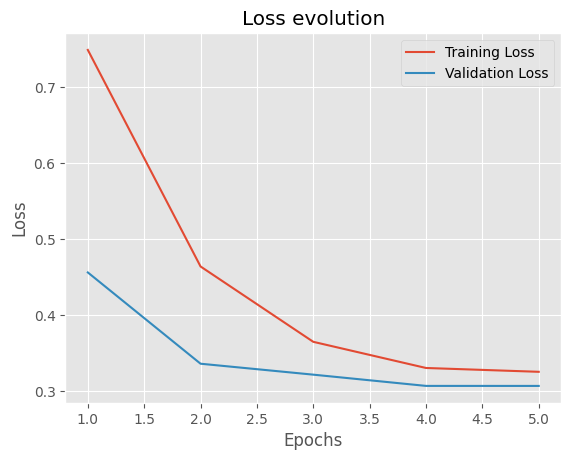

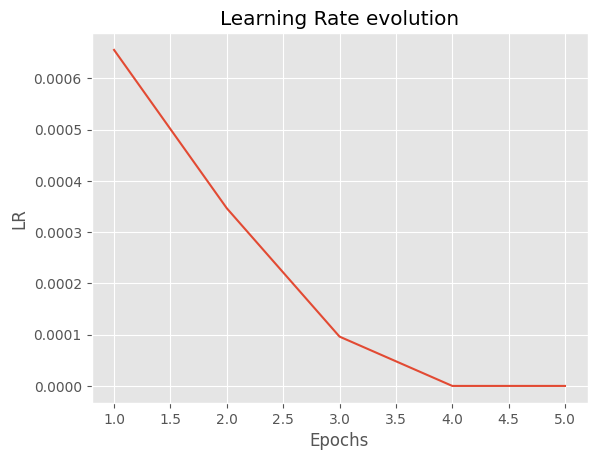

In [11]:
train_loader = DataLoader(
    train_ds,
    batch_size=BS,
    sampler=train_sampler,
    pin_memory=True,
    num_workers=1,
)
valid_loader = DataLoader(
    train_ds,
    batch_size=1,
    sampler=valid_sampler,
    pin_memory=True,
    num_workers=1,
)
for epoch in range(1, EPOCHS + 1):
    train_loss = 0.0
    n_tot_chunks = 0
    pbar = tqdm(
        train_loader, desc="Training", unit="batch"
    )
    model.train()
    for step,(X_batch, y_batch) in enumerate(pbar):
        print("epoch", epoch, "step", step, X_batch.shape, y_batch.shape)
        y_batch = y_batch.to(device, non_blocking=True)
        pred = torch.zeros(y_batch.shape).to(device, non_blocking=True)
        optimizer.zero_grad()
        scheduler.step(step+train_size*epoch)
        h = None

        seq_len = X_batch.shape[1]
        for i in range(0, seq_len, max_chunk_size):
            X_chunk = X_batch[:, i : i + max_chunk_size].float()

            X_chunk = X_chunk.to(device, non_blocking=True)

            y_pred, h = model(X_chunk, h)
            h = [hi.detach() for hi in h]
            pred[:, i : i + max_chunk_size] = y_pred
            del X_chunk,y_pred

        loss = criterion(
            normalize(pred).float(),
            y_batch.float(),
        )
        loss.backward()
        train_loss += loss.item()
        n_tot_chunks+=1
        pbar.set_description(f'Training: loss = {(train_loss/n_tot_chunks):.2f}')

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1e-1)
        optimizer.step()
        del pred,loss,y_batch,X_batch,h
        gc.collect()
    train_loss /= len(train_loader)
    del pbar
    gc.collect()
    ctypes.CDLL("libc.so.6").malloc_trim(0)

    if epoch % 1 == 0:
        valid_loss = evaluate(
            model, max_chunk_size, valid_loader, device, criterion
        )

        history["train_loss"].append(train_loss)
        history["valid_loss"].append(valid_loss)
        history["lr"].append(optimizer.param_groups[0]["lr"])

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(
                model.state_dict(),
                os.path.join(model_path, f"model_best.pth"),
            )

        dt = time.time() - dt
        print(
            f"{epoch}/{EPOCHS} -- ",
            f"train_loss = {train_loss:.6f} -- ",
            f"valid_loss = {valid_loss:.6f} -- ",
            f"time = {dt:.6f}s",
        )
        dt = time.time()

plot_history(history, model_path=model_path)
history_path = os.path.join(model_path, "history.json")
with open(history_path, "w", encoding="utf-8") as f:
    json.dump(history, f, ensure_ascii=False, indent=4)

In [12]:
print("end")

end
